# Pyphasefield

### Installation Requirements

* numpy (pip install numpy)
* matplotlib (pip install matplotlib)
* meshio (pip install meshio)
* (recommended) pycalphad (conda install -c pycalphad -c conda-forge pycalphad)
* (recommended) cudatoolkit (conda install cudatoolkit)
* (recommended) numba (conda install numba)

### Code Format

- pyphasefield
    - Engines
        - Cahn-Allen.py
        - Cahn-Hilliard.py
        - Diffusion.py
        - Dorr2010.py
        - Warren1995.py
        - Karma2001.py
        - NComponent.py
        - NCGPU.py
    - tests
    - examples
    - field.py
    - simulation.py
    - ppf_utils.py
    - ppf_gpu_utils.py
    
pyphasefield/Engines/Cahn-Allen.py: Implementation of Cahn-Allen non-conserved phase field model

pyphasefield/Engines/Cahn-Hilliard.py: Implementation of Cahn-Hilliard conserved phase field model

pyphasefield/Engines/Diffusion.py: Implementation of simple diffusion phase field model

pyphasefield/Engines/Dorr2010.py: Implementation of fully-explicit version of the phase field model from Dorr2010 paper, "A numerical algorithm for the solution of a phase-field model of polycrystalline materials"

pyphasefield/Engines/Warren1995.py: Implementation of the phase field model from Warren1995 paper, "Prediction of Dendritic Growth and Microsegregation Patterns in a Binary Alloy using the Phase-Field Method"

pyphasefield/Engines/Karma2001.py: Implementation of the phase field model from Karma2001 paper, "Phase-Field Formulation for Quantitative Modeling of Alloy Solidification"

pyphasefield/Engines/NComponent.py: Implementation of our N-Component, 2-phase polycrystalline phase field model

pyphasefield/Engines/NCGPU.py: Implementation of our N-Component, 2-phase polycrystalline phase field model using numba to run on a GPU

pyphasefield/field.py: Implementation of the Field class, which stores the field name, and data at each point

pyphasefield/simulation.py: Implementation of the Simulation class, which runs a simulation and allows access to the data from the simulation

pyphasefield/ppf_utils.py: Utility functions for pyphasefield

pyphasefield/ppf_gpu_utils.py: Utility functions specifically for GPU codes, including general-purpose GPU kernels

pyphasefield/tests: pytest files

pyphasefield/examples: example python scripts


### Examples

These are implementations of the example python scripts in the pyphasefield/examples folder, slightly modified to be usable in a ipynb cell

diffusion_example.py:

In [ ]:
import sys
sys.path.insert(0,"..")
import pyphasefield as ppf

sim = ppf.Simulation("data/diffusion_test")
sim.init_sim_Diffusion([20])
sim.plot_simulation()
sim.simulate(100)
sim.save_simulation()
sim.plot_simulation()

Example for DiffusionGPU engine:

In [ ]:
import sys
sys.path.insert(0,"..")
import pyphasefield as ppf

sim = ppf.Simulation("data/diffusionGPU_test")
sim.init_sim_DiffusionGPU([200, 200], cuda_blocks=(16,16), cuda_threads_per_block=(256,1))
sim.send_fields_to_GPU()
sim.plot_simulation()
sim.simulate(1000)
sim.save_simulation()
sim.plot_simulation()

warren1995_example.py:

In [ ]:
import sys
sys.path.insert(0,"..")
import pyphasefield as ppf
import matplotlib.pyplot as plt

sim = ppf.Simulation(save_path="data/warren1995_test")
sim.init_sim_Warren1995([200, 200], diamond_size=10)
sim.plot_simulation()
for i in range(10):
    sim.simulate(50)
    print(str((i+1)*10)+"% done!")
sim.plot_simulation()

NComponent_example.py (requires pycalphad):

In [ ]:
import sys
sys.path.insert(0,"..")
import numpy as np
import pyphasefield as ppf

saveloc = input("What folder in data to save under? ")
sim = ppf.Simulation(save_path="data/"+saveloc)
sim.init_sim_NComponent(dim=[200, 200], tdb_path="examples/Ni-Cu_Ideal.tdb", sim_type="seed", initial_temperature=1574, initial_concentration_array=[0.3937])
initial_step = int(input("What step to load from? (-1 = new simulation) "))
if(initial_step == -1):
    sim.save_simulation()
else:
    sim.load_simulation(step=initial_step)
sim._time_steps_per_checkpoint = 1000
sim._boundary_conditions_type = ["periodic", "periodic"]
sim.fields[1].data[:] = np.cos(np.pi/8)
sim.fields[2].data[:] = np.sin(np.pi/8)

totalsteps = int(input("How many steps to run? (10000 for a decent sized dendrite, ~10 minutes) "))
progress_bar_steps=int(totalsteps/20)
for i in range(20):
    sim.simulate(progress_bar_steps)
    print(str((i+1)*progress_bar_steps)+" steps completed out of "+str(totalsteps))
sim.simulate(totalsteps-20*progress_bar_steps)
print("Completed!")

sim.plot_simulation()

NCGPU example (requires pycalphad, numba, and cudatoolkit):

In [ ]:
import sys
sys.path.insert(0,"..")
import numpy as np
import pyphasefield as ppf


saveloc = input("What folder in data to save under?")
sim = ppf.Simulation(save_path="data/"+saveloc)
sim.init_sim_NCGPU(dim=[200, 200], tdb_path="examples/Ni-Cu_Ideal.tdb", sim_type="seed", initial_temperature=1574, initial_concentration_array=[0.3937])
initial_step = int(input("What step to load from? (-1 = new simulation)"))
if(initial_step == -1):
    sim.save_simulation()
else:
    sim.load_simulation(step=initial_step)
sim._time_steps_per_checkpoint = 1000
sim._boundary_conditions_type = ["periodic", "periodic"]
sim.fields[1].data[:] = np.cos(np.pi/8)
sim.fields[2].data[:] = np.sin(np.pi/8)

totalsteps = int(input("How many steps to run? (10000 for a decent sized dendrite)"))
progress_bar_steps=int(totalsteps/20)

#only significant difference between the codes - need to send data to the GPU
sim.send_fields_to_GPU()

for i in range(20):
    sim.simulate(progress_bar_steps)
    print(str((i+1)*progress_bar_steps)+" steps completed out of "+str(totalsteps))
sim.simulate(totalsteps-20*progress_bar_steps)
print("Completed!")

sim.plot_simulation()

#slight differences will be observed due to different discretization schemes used in GPU version at present

In [ ]:
import sys
sys.path.insert(0,"..")
import pyphasefield as ppf

sim = ppf.Simulation("save_path")
sim.init_sim_NCGPU(dim=[200, 200], 
                   tdb_path="examples/Ni-Cu_Ideal.tdb", 
                   sim_type="seed", 
                   initial_concentration_array=[0.3937]
                  )
sim._time_steps_per_checkpoint = 1000
sim.send_fields_to_GPU()
sim.simulate(10000)
sim.plot_simulation(save_images=True)


In [ ]:
import sys
sys.path.insert(0,"..")
import pyphasefield.Engines as engines
dir(engines)

In [ ]:
import sys
sys.path.insert(0,"..")
import pyphasefield.Engines as engines


sim = engines.Diffusion(dimensions=[200, 200])

#initialize non-array parameters
sim.set_framework("CPU_SERIAL") #"CPU_SERIAL", "GPU_SERIAL"
sim.set_dx(1.)
sim.set_dt(0.1)
sim.set_time_step_counter(0)
sim.set_temperature_type(None) #None, "ISOTHERMAL", "LINEAR_GRADIENT", "XDMF_FILE"
sim.set_temperature_initial_T(None)
sim.set_temperature_dTdx(None)
sim.set_temperature_dTdy(None)
sim.set_temperature_dTdz(None)
sim.set_temperature_dTdt(None)
sim.set_temperature_path(None)
sim.set_temperature_units(None)
sim.set_tdb_path(None)
sim.set_tdb_phases(None)
sim.set_tdb_components(None)
sim.set_save_path(None)
sim.set_autosave_flag(False)
sim.set_autosave_save_images_flag(False)
sim.set_autosave_rate(100000)
sim.set_boundary_conditions("PERIODIC")

data = {
    "D":1.
}
sim.set_user_data(data)

#initialize simulation arrays, all parameter changes should be BEFORE this point!
sim.initialize_fields_and_imported_data()

#change array data here, for custom simulations


#run simulation
sim.simulate(2000)
sim.plot_simulation(save_images=False)

In [ ]:
import sys
sys.path.insert(0,"..")
import pyphasefield.Engines as engines
import matplotlib.pyplot as plt


sim = engines.Pathway_NNYNN(dimensions=[800, 800])

#initialize non-array parameters
sim.set_framework("GPU_SERIAL") #"CPU_SERIAL", "GPU_SERIAL"
sim.set_dx(0.0000046)
sim.set_time_step_counter(0)
sim.set_temperature_type("ISOTHERMAL") #None, "ISOTHERMAL", "LINEAR_GRADIENT", "XDMF_FILE"
sim.set_temperature_initial_T(1574.)
sim.set_temperature_dTdx(None)
sim.set_temperature_dTdy(None)
sim.set_temperature_dTdz(None)
sim.set_temperature_dTdt(None)
sim.set_temperature_path(None)
sim.set_temperature_units("K")
sim.set_tdb_path(None)
sim.set_tdb_phases(None)
sim.set_tdb_components(None)
sim.set_save_path(None)
sim.set_autosave_flag(False)
sim.set_autosave_save_images_flag(False)
sim.set_autosave_rate(100000)
sim.set_boundary_conditions("NEUMANN")

data = {
    "d_ratio":1.1,
    "sim_type":"seed",
    "initial_concentration_array":[0.40831]
}
sim.set_user_data(data)

#initialize simulation arrays, all parameter changes should be BEFORE this point!
sim.initialize_fields_and_imported_data()

#change array data here, for custom simulations


#run simulation
sim.simulate(30000)
sim.plot_simulation(interpolation="nearest", save_images=False)
#print(sim.fields[1].data)

In [ ]:
import sys
sys.path.insert(0,"..")
import pyphasefield.Engines as engines
import matplotlib.pyplot as plt
import numpy as np


sim = engines.Pathway_YYNNN(dimensions=[800, 800])

#initialize non-array parameters
sim.set_framework("GPU_SERIAL") #"CPU_SERIAL", "GPU_SERIAL"
sim.set_dx(0.0000046)
sim.set_time_step_counter(0)
sim.set_temperature_type("ISOTHERMAL") #None, "ISOTHERMAL", "LINEAR_GRADIENT", "XDMF_FILE"
sim.set_temperature_initial_T(1574.)
sim.set_temperature_dTdx(None)
sim.set_temperature_dTdy(None)
sim.set_temperature_dTdz(None)
sim.set_temperature_dTdt(None)
sim.set_temperature_path(None)
sim.set_temperature_units("K")
sim.set_tdb_path(None)
sim.set_tdb_phases(None)
sim.set_tdb_components(None)
sim.set_save_path(None)
sim.set_autosave_flag(False)
sim.set_autosave_save_images_flag(False)
sim.set_autosave_rate(100000)
sim.set_boundary_conditions("NEUMANN")

data = {
    "d_ratio":1.1,
    "sim_type":"seed",
    "melt_angle":np.pi/4.,
    "initial_concentration_array":[0.40831]
}
sim.set_user_data(data)

#initialize simulation arrays, all parameter changes should be BEFORE this point!
sim.initialize_fields_and_imported_data()

#change array data here, for custom simulations


#run simulation
sim.simulate(30000)
sim.plot_simulation(interpolation="nearest", save_images=False)
#print(sim.fields[1].data)

In [ ]:
import sys
sys.path.insert(0,"..")
import pyphasefield.Engines as engines
import matplotlib.pyplot as plt
import numpy as np


sim = engines.Pathway_YYYNN(dimensions=[800, 800])

#initialize non-array parameters
sim.set_framework("GPU_SERIAL") #"CPU_SERIAL", "GPU_SERIAL"
sim.set_dx(0.0000046)
sim.set_time_step_counter(0)
sim.set_temperature_type("ISOTHERMAL") #None, "ISOTHERMAL", "LINEAR_GRADIENT", "XDMF_FILE"
sim.set_temperature_initial_T(1574.)
sim.set_temperature_dTdx(None)
sim.set_temperature_dTdy(None)
sim.set_temperature_dTdz(None)
sim.set_temperature_dTdt(None)
sim.set_temperature_path(None)
sim.set_temperature_units("K")
sim.set_tdb_path("tests/Ni-Cu_Ideal.tdb")
sim.set_tdb_phases(None)
sim.set_tdb_components(None)
sim.set_save_path(None)
sim.set_autosave_flag(False)
sim.set_autosave_save_images_flag(False)
sim.set_autosave_rate(100000)
sim.set_boundary_conditions("NEUMANN")

data = {
    "d_ratio":1.1,
    "sim_type":"seed",
    "initial_concentration_array":[0.3937]
}
sim.set_user_data(data)

#initialize simulation arrays, all parameter changes should be BEFORE this point!
sim.initialize_fields_and_imported_data()

#change array data here, for custom simulations


#run simulation
sim.simulate(30000)
sim.plot_simulation(interpolation="nearest", save_images=False)
#print(sim.fields[1].data)

In [ ]:
import sys
sys.path.insert(0,"..")
import pyphasefield.Engines as engines
import matplotlib.pyplot as plt
import numpy as np


sim = engines.Pathway_YYYYN(dimensions=[800, 800])

#initialize non-array parameters
sim.set_framework("GPU_SERIAL") #"CPU_SERIAL", "GPU_SERIAL"
sim.set_dx(0.0000046)
sim.set_time_step_counter(0)
sim.set_temperature_type("ISOTHERMAL") #None, "ISOTHERMAL", "LINEAR_GRADIENT", "XDMF_FILE"
sim.set_temperature_initial_T(1574.)
sim.set_temperature_dTdx(None)
sim.set_temperature_dTdy(None)
sim.set_temperature_dTdz(None)
sim.set_temperature_dTdt(None)
sim.set_temperature_path(None)
sim.set_temperature_units("K")
sim.set_tdb_path("tests/Ni-Cu_Ideal.tdb")
sim.set_tdb_phases(None)
sim.set_tdb_components(None)
sim.set_save_path(None)
sim.set_autosave_flag(False)
sim.set_autosave_save_images_flag(False)
sim.set_autosave_rate(100000)
sim.set_boundary_conditions("NEUMANN")

data = {
    "d_ratio":1.1,
    "sim_type":"seed",
    "initial_concentration_array":[0.3937]
}
sim.set_user_data(data)

#initialize simulation arrays, all parameter changes should be BEFORE this point!
sim.initialize_fields_and_imported_data()

#change array data here, for custom simulations


#run simulation
sim.simulate(30000)
sim.plot_simulation(interpolation="nearest", save_images=False)
#print(sim.fields[1].data)

In [ ]:
import sys
sys.path.insert(0,"..")
import pyphasefield.Engines as engines
import matplotlib.pyplot as plt
import numpy as np


sim = engines.Pathway_YYYYY(dimensions=[800, 800])

#initialize non-array parameters
sim.set_framework("GPU_SERIAL") #"CPU_SERIAL", "GPU_SERIAL"
sim.set_dx(0.0000046)
sim.set_time_step_counter(0)
sim.set_temperature_type("ISOTHERMAL") #None, "ISOTHERMAL", "LINEAR_GRADIENT", "XDMF_FILE"
sim.set_temperature_initial_T(1574.)
sim.set_temperature_dTdx(None)
sim.set_temperature_dTdy(None)
sim.set_temperature_dTdz(None)
sim.set_temperature_dTdt(None)
sim.set_temperature_path(None)
sim.set_temperature_units("K")
sim.set_tdb_path("tests/Ni-Cu_Ideal.tdb")
sim.set_tdb_phases(None)
sim.set_tdb_components(None)
sim.set_save_path(None)
sim.set_autosave_flag(False)
sim.set_autosave_save_images_flag(False)
sim.set_autosave_rate(100000)
sim.set_boundary_conditions("NEUMANN")

data = {
    "d_ratio":1.1,
    "sim_type":"seed",
    "initial_concentration_array":[0.3937]
}
sim.set_user_data(data)

#initialize simulation arrays, all parameter changes should be BEFORE this point!
sim.initialize_fields_and_imported_data()

#change array data here, for custom simulations


#run simulation
sim.simulate(30000)
sim.plot_simulation(interpolation="nearest", save_images=False)
#print(sim.fields[1].data)

In [ ]:
sim.simulate(20000)
sim.plot_simulation(interpolation="nearest", save_images=False)

In [ ]:
import sys
sys.path.insert(0,"..")
import pyphasefield.Engines as engines
import matplotlib.pyplot as plt
import numpy as np


sim = engines.NCGPU_new(dimensions=[800, 800])

#initialize non-array parameters
sim.set_framework("GPU_SERIAL") #"CPU_SERIAL", "GPU_SERIAL"
sim.set_dx(0.0000046)
sim.set_time_step_counter(0)
sim.set_temperature_type("ISOTHERMAL") #None, "ISOTHERMAL", "LINEAR_GRADIENT", "XDMF_FILE"
sim.set_temperature_initial_T(1574.)
sim.set_temperature_dTdx(None)
sim.set_temperature_dTdy(None)
sim.set_temperature_dTdz(None)
sim.set_temperature_dTdt(None)
sim.set_temperature_path(None)
sim.set_temperature_units("K")
sim.set_tdb_path("tests/Ni-Cu-Al_Ideal.tdb")
#sim.set_tdb_path("tests/Ni-Nb_Simplified.tdb")
#sim.set_tdb_path("tests/mc_ni_v2.034.pycalphad.tdb")
sim.set_tdb_phases(["FCC_A1", "LIQUID"])
sim.set_tdb_components(["AL", "CU", "NI"])
sim.set_save_path(None)
sim.set_autosave_flag(False)
sim.set_autosave_save_images_flag(False)
sim.set_autosave_rate(100000)
sim.set_boundary_conditions("NEUMANN")

data = {
    "d_ratio":1.1,
    "sim_type":"seed",
    "initial_concentration_array":[0.0001, 0.3937]
}
sim.set_user_data(data)

#initialize simulation arrays, all parameter changes should be BEFORE this point!
sim.initialize_fields_and_imported_data()

#change array data here, for custom simulations


#run simulation
sim.simulate(10000)
sim.plot_simulation(interpolation="nearest", save_images=False)
#print(sim.fields[1].data)

In [1]:
import sys
sys.path.insert(0,"..")
import pyphasefield as ppf
import pyphasefield.Engines as engines
import matplotlib.pyplot as plt
import numpy as np

tdbc = ppf.TDBContainer("tests/mc_simplified.tdb", ["FCC_A1", "LIQUID"], ["AL", "CR", "FE", "MO", "NB", "NI", "TI"])

No module named 'pyphasefield.utils'


C:\Users\scott\anaconda3\lib\site-packages\pycalphad\io\tdb.py:965: UserWarning: The type definition character `%` was defined in the following phases: ['LIQUID', 'FCC_A1'], but no corresponding TYPE_DEFINITION line was found in the TDB.
  warnings.warn(f"The type definition character `{typechar}` was defined in the following phases: "


self.user_data["seed_angle"] not defined, defaulting to pi/4


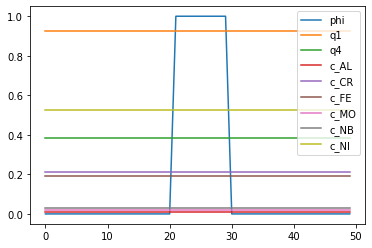

In [7]:
import sys
sys.path.insert(0,"..")
import pyphasefield as ppf
import pyphasefield.Engines as engines
import matplotlib.pyplot as plt
import numpy as np


#sim = engines.NCGPU_new(dimensions=[1142, 3240])
sim = engines.NCGPU_new(dimensions=[1, 50])
#sim = engines.NCGPU_new(dimensions=[326, 218])
#sim = engines.NCGPU_new(dimensions=[58, 130])

#initialize non-array parameters
sim.set_framework("GPU_SERIAL") #"CPU_SERIAL", "GPU_SERIAL"
sim.set_dx(0.0000046)
sim.set_time_step_counter(0)
sim.set_temperature_type("ISOTHERMAL") #None, "ISOTHERMAL", "LINEAR_GRADIENT", "XDMF_FILE"
#sim.set_temperature_type("LINEAR_GRADIENT") 
#sim.set_temperature_type("XDMF_FILE")
sim.set_temperature_initial_T(1584.)
sim.set_temperature_dTdx(0.)
sim.set_temperature_dTdy(0.)
sim.set_temperature_dTdz(0.)
sim.set_temperature_dTdt(-200000.)
sim.set_temperature_path("data/mchs_small/T.xdmf")
#sim.set_temperature_path("data/newthermal/T.xdmf")
sim.set_temperature_units("K")
sim.set_tdb_container(tdbc)
#sim.set_tdb_path("tests/Ni-Cu-Al_Ideal.tdb")
#sim.set_tdb_phases(["FCC_A1", "LIQUID"])
#sim.set_tdb_components(["AL", "CU", "NI"])
#sim.set_save_path(None)
sim.set_save_path("data/equil_test_1584")
#sim.set_save_path("data/newthermal")
#sim.set_autosave_flag(True)
sim.set_autosave_flag(True)
sim.set_autosave_save_images_flag(False)
sim.set_autosave_rate(25000)
sim.set_boundary_conditions("PERIODIC")
#sim.set_boundary_conditions("NEUMANN")

data = {
    "d_ratio":2.,
    "sim_type":"seed",
    "melt_angle":np.pi/4.,
    "number_of_seeds":30,
    "initial_concentration_array":[0.011, 0.212, 0.192, 0.018, 0.031, 0.524]
}
sim.set_user_data(data)

#
#"initial_concentration_array":[0.001, 0.3937]
#"initial_concentration_array":[0.011, 0.21, 0.231, 0.031]
#"initial_concentration_array":[0.011, 0.212, 0.192, 0.018, 0.031, 0.524]

#initialize simulation arrays, all parameter changes should be BEFORE this point!
sim.initialize_fields_and_imported_data()
sim.user_data["H"] = 0.00000000001
sim.user_data["M_qmax"] = 12000000000.
sim.user_data["D_L"] = 0.00024
sim.user_data["D_S"] = 0.00024

#change array data here, for custom simulations
#sim.load_simulation(step=93800)
sim.fields[0].colormap = ppf.COLORMAP_PHASE
for i in range(3, len(sim.fields)):
    sim.fields[i].colormap = "gist_rainbow"

#run simulation
for i in range(1):
    sim.simulate(0)
    sim.plot_simulation(interpolation="nearest", save_images=False)
#print(sim.fields[1].data)

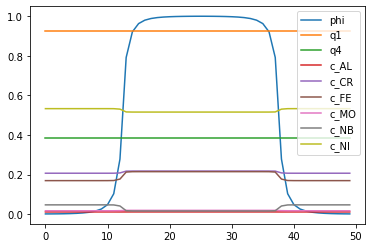

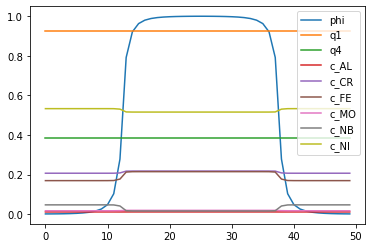

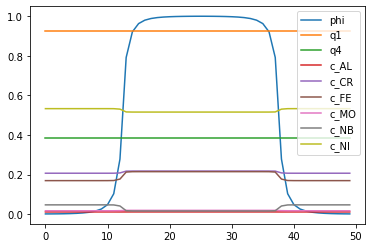

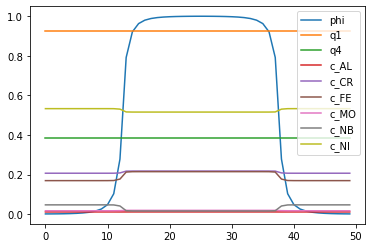

In [10]:
for i in range(4):
    sim.simulate(10000)
    sim.plot_simulation(interpolation="nearest", save_images=False)

In [25]:
sim.save_simulation()

0

In [ ]:
#np.sum(sim.fields[6].data)
#sim.fields[8].data
plt.figure(figsize=[16,6])
i=0
plt.imshow(sim.fields[i].data[290:400], cmap=sim.fields[i].colormap)

In [18]:
sim.temperature.data

array([[1542.60575, 1542.60575, 1542.60575, 1542.60575, 1542.60575,
        1542.60575, 1542.60575, 1542.60575, 1542.60575, 1542.60575,
        1542.60575, 1542.60575, 1542.60575, 1542.60575, 1542.60575,
        1542.60575, 1542.60575, 1542.60575, 1542.60575, 1542.60575,
        1542.60575, 1542.60575, 1542.60575, 1542.60575, 1542.60575,
        1542.60575, 1542.60575, 1542.60575, 1542.60575, 1542.60575,
        1542.60575, 1542.60575, 1542.60575, 1542.60575, 1542.60575,
        1542.60575, 1542.60575, 1542.60575, 1542.60575, 1542.60575,
        1542.60575, 1542.60575, 1542.60575, 1542.60575, 1542.60575,
        1542.60575, 1542.60575, 1542.60575, 1542.60575, 1542.60575,
        1542.60575, 1542.60575, 1542.60575, 1542.60575, 1542.60575,
        1542.60575, 1542.60575, 1542.60575, 1542.60575, 1542.60575,
        1542.60575, 1542.60575, 1542.60575, 1542.60575, 1542.60575,
        1542.60575, 1542.60575, 1542.60575, 1542.60575, 1542.60575,
        1542.60575, 1542.60575, 1542.60575, 1542

In [ ]:
sim.fields[8].data

In [ ]:
sim.fields[0].colormap = ppf.COLORMAP_PHASE
for i in range(3, len(sim.fields)):
    sim.fields[i].colormap = "gist_rainbow"
sim.plot_simulation(interpolation="nearest", size=[16,6], save_images=False)

In [ ]:
c_TI = np.ones(sim.dimensions)
for i in range(3, len(sim.fields)):
    c_TI -= sim.fields[i].get_cells()
plt.figure(figsize=[16,6])
plt.imshow(c_TI, interpolation="nearest", cmap=sim.fields[3].colormap)
plt.title("c_TI")
plt.colorbar()
plt.show()

In [ ]:
al = 26.9815
cr = 51.9961
fe = 55.845
mo = 95.94
nb = 92.9064
ni = 58.6934
ti = 47.867

m = 40
n = 160
l = 50
x = np.arange(m, n)
x *= 46
y1 = 0+sim.fields[3].get_cells()[l, m:n]
y2 = 0+sim.fields[4].get_cells()[l, m:n]
y3 = 0+sim.fields[5].get_cells()[l, m:n]
y4 = 0+sim.fields[6].get_cells()[l, m:n]
y5 = 0+sim.fields[7].get_cells()[l, m:n]
y6 = 0+sim.fields[8].get_cells()[l, m:n]
y7 = 1.-y1-y2-y3-y4-y5-y6
#plt.plot(x, y1, "k")
plt.plot(x, y2, "k")
plt.plot(x, y3, "k")
plt.plot(x, y4, "r")
plt.plot(x, y5, "k")
plt.plot(x, y6, "k")
plt.plot(x, y7, "b")
plt.show()
y1 *= al
y2 *= cr
y3 *= fe
y4 *= mo
y5 *= nb
y6 *= ni
y7 *= ti
_sum = 0.01*(y1+y2+y3+y4+y5+y6+y7)
y1 = y1/_sum
y2 = y2/_sum
y3 = y3/_sum
y4 = y4/_sum
y5 = y5/_sum
y6 = y6/_sum
y7 = y7/_sum


#plt.plot(x, y1, "k")
plt.plot(x, y2, color=(81./255, 126./255, 123./255))
plt.plot(x, y3, color=(209./255, 32./255, 248./255))
plt.plot(x, y4, "r")
plt.plot(x, y5, "k")
plt.plot(x, y6, color=(116./255, 122./255, 43./255))
plt.plot(x, y7, "b")
plt.legend(["CR", "FE", "MO", "NB", "NI", "TI"])
plt.ylabel("wt%")
plt.xlabel("d (nm)")
plt.show()

In [ ]:
plt.imshow(sim.fields[3].data)

In [ ]:
for i in range(4):
    for j in range(25):
        sim.simulate(1000)
        print(str(j+1)+" out of 25 iterations done per save cycle")
    print("Saving!")
    sim.plot_simulation(interpolation="nearest", save_images=False)

In [ ]:
c_NI = np.ones(sim.dimensions)
for i in range(3, len(sim.fields)):
    c_NI -= sim.fields[i].get_cells()
plt.imshow(c_NI, interpolation="nearest", cmap=sim.fields[3].colormap)
plt.title("c_NI")
plt.colorbar()
plt.show()

In [ ]:
import sys
sys.path.insert(0,"..")
import pyphasefield.Engines as engines
import matplotlib.pyplot as plt


sim = engines.NCGPU_new(dimensions=[100, 100])

#initialize non-array parameters
sim.set_framework("GPU_SERIAL") #"CPU_SERIAL", "GPU_SERIAL"
sim.set_dx(0.0000046)
sim.set_time_step_counter(0)
sim.set_temperature_type("ISOTHERMAL") #None, "ISOTHERMAL", "LINEAR_GRADIENT", "XDMF_FILE"
sim.set_temperature_initial_T(1574.)
sim.set_temperature_dTdx(None)
sim.set_temperature_dTdy(None)
sim.set_temperature_dTdz(None)
sim.set_temperature_dTdt(None)
sim.set_temperature_path(None)
sim.set_temperature_units("K")
sim.set_tdb_path("tests/Ni-Cu_Ideal.tdb")
sim.set_tdb_phases(None)
sim.set_tdb_components(None)
sim.set_save_path(None)
sim.set_autosave_flag(False)
sim.set_autosave_save_images_flag(False)
sim.set_autosave_rate(100000)
sim.set_boundary_conditions("NEUMANN")

data = {
    "d_ratio":1.1,
    "sim_type":"seed",
    "initial_concentration_array":[0.3937]
}
sim.set_user_data(data)

#initialize simulation arrays, all parameter changes should be BEFORE this point!
sim.initialize_fields_and_imported_data()

#change array data here, for custom simulations


#run simulation
sim.simulate(1000)
sim.plot_simulation(interpolation="nearest", save_images=False)
#print(sim.fields[1].data)

In [ ]:
sim.simulate(15000)
sim.plot_simulation(interpolation="nearest", save_images=False)